<a href="https://colab.research.google.com/github/Schify/FacExcerciseBook/blob/andras/DL_homewokr_trainingipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#A libary that will help us plot the neural network so we can better visualize it
!pip install -q pydot
!apt install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [3]:
#loading all the necessary libraries for the project
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm.notebook import tqdm #useful module for progress bars
import logging
import gc
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from datetime import datetime
!pip install keras_facenet
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
from keras_facenet import FaceNet
import shutil
from keras.utils.vis_utils import plot_model
embedder = FaceNet()
OHEC =OneHotEncoder()

     |████████████████████████████████| 2.3 MB 7.4 MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10386 sha256=0cc5602758e58de864315be5cb2447ea077f81c4edf099a67d9d72c8b5fd2f08
  Stored in directory: /root/.cache/pip/wheels/2b/76/1a/a29ceb07bfca098e2b0bc8690d550753a0384cbed26d5f47ee
Successfully built keras-facenet


In [4]:
#reading the csv file that contains the labels with pandas
train_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/train.csv")
val_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/val.csv")

In [5]:
#displaying the training labels
train_label_raw.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [6]:
#dispalying the validation labels
val_label_raw.head()

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False


In [7]:
#Here we used sklearn in order to onehotencode our data thus preparing it for the CNN network
OHEC =OneHotEncoder()
"""
OHEC.fit(X=[["0-2", "Male", "Black", "False"],["3-9", "Female", "Indian", "True"],
["10-19", "Male", "East Asian", "False"],["20-29", "Male", "Southeast Asian", "False"],
["30-39", "Male", "Latino_Hispanic", "False"],["40-49", "Male", "Middle Eastern", "False"],["50-59", "Male", "White", "False"],
["60-69", "Male", "Middel Eastern", "False"],["more than 70", "Male", "White", "False"]])
"""
#The one hot encoder arranges the inputs in alphabetic order
OHEC.fit(val_label_raw[["age", "gender", "race", "service_test"]])
val_label = OHEC.transform(val_label_raw[["age", "gender", "race", "service_test"]]).toarray()
train_label = OHEC.transform(train_label_raw[["age", "gender", "race", "service_test"]]).toarray()
#We are putting thes together inside this npz dataformat
np.savez("labels.npz", train=train_label, val=val_label)

In [8]:
#loading the labels from the drive
labels=np.load("labels.npz")

In [9]:
#loading the embeddings from the drive
train_embeddings = np.load("gdrive/MyDrive/DL_big_homework/train_embedding.npz")["train"]
train_labels = np.load("gdrive/MyDrive/DL_big_homework/labels.npz")["train"][0:train_embeddings.shape[0]]
print(train_labels.shape)

(5204, 20)


In [10]:
valid_embeddings = np.load("gdrive/MyDrive/DL_big_homework/val_embedding.npz")["val"]
valid_labels = np.load("gdrive/MyDrive/DL_big_homework/labels.npz")["val"][0:valid_embeddings.shape[0]]
print(valid_labels.shape)

(547, 20)


In [11]:
test_embeddings = np.load("gdrive/MyDrive/DL_big_homework/test_embedding.npz")["val"]
test_labels = np.load("gdrive/MyDrive/DL_big_homework/labels.npz")["val"][0:test_embeddings.shape[0]]
print(test_labels.shape)

(54, 20)


Model: "OpenFace_extension"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 128)          65664       ['input_4[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['dense_16[0][0]']               
                                                                                                  
 dense_17 (Dense)               (None, 128)          16512       ['dropout_4[0][0]']              
                                                                                 

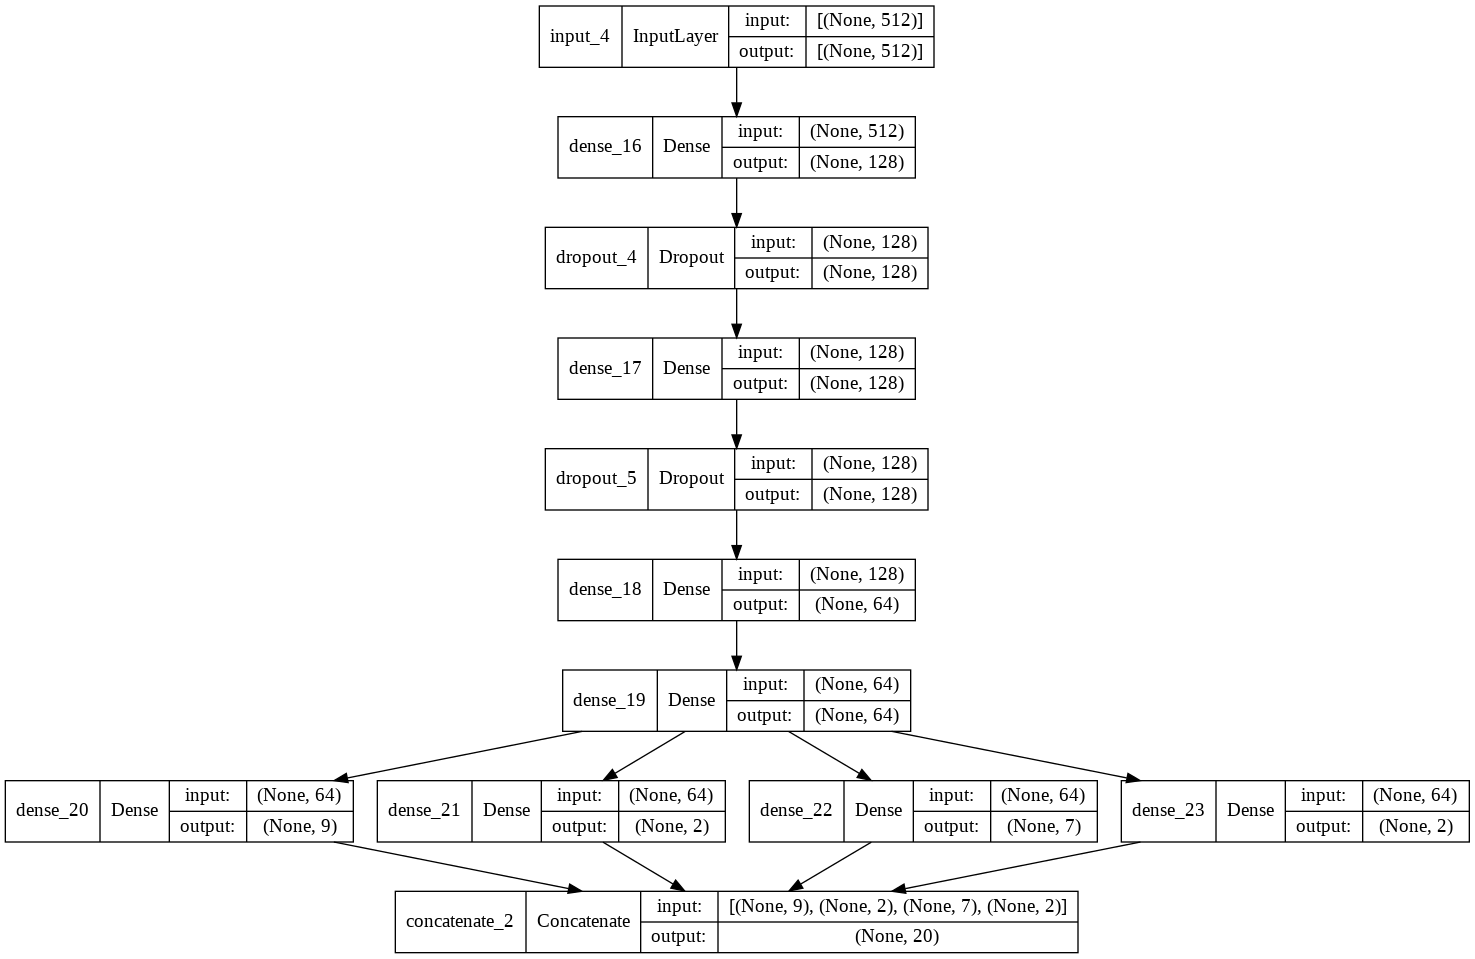

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=8)
#creating the neural network
inputs = keras.Input(shape=(train_embeddings.shape[1],))
x = keras.layers.Dense(128, activation='sigmoid')(inputs)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Dense(128, activation='sigmoid')(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Dense(64, activation='sigmoid')(x)
x = keras.layers.Dense(64, activation='sigmoid')(x)

#each category needs to have its own softmax activation layer 
xs = [keras.layers.Dense(values.shape[0], activation="softmax")(x) for values in OHEC.categories_]#separate categories
outputs = tf.keras.layers.Concatenate()(xs)

model = keras.Model(inputs = inputs, outputs = outputs, name="OpenFace_extension")

model.summary()
#visualizing the model
plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(),#every bit needs to converge, maybe weighting is also needed
    optimizer="Adam",
    metrics=["binary_accuracy"])#every bit has to be looked at separately

In [20]:
model.fit(train_embeddings,train_labels, validation_data=(valid_embeddings, valid_labels),batch_size = 32,epochs=100, callbacks=[callback])

Epoch 1/100
163/163 [==============================] - 2s 6ms/step - loss: 0.4233 - binary_accuracy: 0.8031 - val_loss: 0.4261 - val_binary_accuracy: 0.7923
Epoch 2/100
163/163 [==============================] - 1s 5ms/step - loss: 0.4214 - binary_accuracy: 0.8019 - val_loss: 0.4259 - val_binary_accuracy: 0.8031
Epoch 3/100
163/163 [==============================] - 1s 5ms/step - loss: 0.4211 - binary_accuracy: 0.8032 - val_loss: 0.4270 - val_binary_accuracy: 0.8077
Epoch 4/100
163/163 [==============================] - 1s 5ms/step - loss: 0.4213 - binary_accuracy: 0.8034 - val_loss: 0.4251 - val_binary_accuracy: 0.8077
Epoch 5/100
163/163 [==============================] - 1s 5ms/step - loss: 0.4213 - binary_accuracy: 0.8027 - val_loss: 0.4280 - val_binary_accuracy: 0.7969
Epoch 6/100
163/163 [==============================] - 1s 5ms/step - loss: 0.4212 - binary_accuracy: 0.8037 - val_loss: 0.4262 - val_binary_accuracy: 0.8031
Epoch 7/100
163/163 [==============================] - 1s 

In [ ]:
class MulticatLoss(keras.losses.Loss):
        def __init__(self):
            super(MulticatLoss, self).__init__()
            cce = keras.losses.CategoricalCrossentropy()

        def call(self, y_true, y_pred):
            return cce(y_true[0:9], y_pred[0:9])+cce(y_true[9:11], y_pred[9:11])+cce(y_true[11:18], y_pred[11:18])+cce(y_true[18:20], y_pred[18:20])

In [21]:
predictions=model.predict(test_embeddings)

In [22]:
label_list=["0-2","10-19","20-29","3-9","30-39","40-49","50-59","60-69",
            "more than 70","Female","Male","Balck","East Asian","Indian",
            "Latino_hispanic","Middle_easern", "Southest Asian","White","False","True"]

In [74]:
#unpacking the predictions and rounding the numbers
for i in range(5)
  age=max(predictions[i][0:9])
  age_index=list(predictions[i]).index(age)
  predictions[i][age_index]=1
  sex=max(predictions[i][9:11])
  sex_index=list(predictions[i]).index(sex)
  predictions[2][sex_index]=1

In [77]:
ethnicity=max(predictions[i][11:18])
ethnicity_index=list(predictions[I]).index(ethnicity)
predictions[2][ethnicity_index]=1

In [78]:
t_f=max(predictions[2][18:20])
t_f_index=list(predictions[2]).index(t_f)
predictions[2][t_f_index]=1

In [79]:
round_preds=np.round(predictions[2])

In [80]:
#creating the indexes for the table
x=[i for i, x in enumerate(round_preds) if x == 1]

In [81]:
#looking up the labels in the label list
predicted=[]
for i in range(4):
  predicted.append(label_list[x[i]])

Text(0.5, 1.0, "['20-29', 'Male', 'White', 'False']")

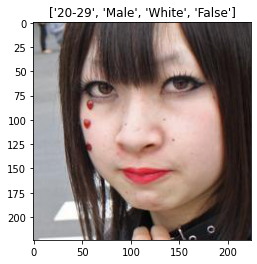

In [86]:
#loading and polotting an image that we will provide at the github repo
img = plt.imread("100.jpg")
plt.imshow(img)
plt.title(predicted)

In [87]:
predicted

['20-29', 'Male', 'White', 'False']